# After sales text clustering using Doc2Vec
## Enhanced corpus with more data

In [1]:
import pandas as pd
import numpy as np
import spacy
nlp = spacy.load('es_core_news_sm')
# nlp = spacy.load('es_core_news_md')
# nlp = spacy.load('es_core_news_sm')
import multiprocessing
from datetime import date
import matplotlib.pyplot as plt
import os
import gensim.models.doc2vec
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
pd.options.mode.chained_assignment = None

data_version = "2024-05-14"
corpus_version = '2024-05-15'
model_version = '2024-05-15'
data_base_path = f"../DATA/processed/"
model_base_path = f"../MODELS/{data_version}"

In [2]:
# Function to preprocess the text
def preprocess_text(docs):
    # Ensure all entries are strings
    docs = docs.fillna("").astype(str)
    # Process the text
    texts = [doc for doc in nlp.pipe(docs, disable=["ner", "parser"])] 
    processed_texts = []
    for doc in texts:
        tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_stop and not token.is_space]
        processed_texts.append(' '.join(tokens))
    return processed_texts

In [3]:
# Class Model with comments
class CommentedDoc2Vec(Doc2Vec):
    def __init__(self, comment="", **kwargs):
        super().__init__(**kwargs)
        self.comment = comment

In [4]:
# Load train corpus from disk
corpus = pd.read_csv('../DATA/processed/2024-05-15/corpus_spanish.csv', sep='¬')
corpus['text_to_analyse'] = corpus['text_to_analyse'].fillna("").astype(str)  # Ensure all values are strings
corpus['processed_text'] = preprocess_text(corpus['text_to_analyse'])
corpus = corpus[corpus['processed_text'] != ""]
#corpus = pd.read_csv(f'../DATA/processed/{corpus_version}/corpus_processed.csv', sep='¬')
corpus.sample(10)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_16224\563515328.py:2: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  corpus = pd.read_csv('../DATA/processed/2024-05-15/corpus_spanish.csv', sep='¬')


,text_to_analyse,language,processed_text
94781,CARACTERÍSTICAS TÉCNICAS \n \n \n \n \n \n \...,es,características técnicas unidades compatibles ...
56399,"No obstante, si teniendo una programación desh...",es,obstante teniendo programación deshabilitada r...
80471,16\nESRESETEO DEL SISTEMA\nCAMBIO DE BATERÍAEn...,es,16 esreseteo sistema cambio bateríaen caso nec...
89196,\n27 \n \n \n \nEn el caso del Supermaestr...,es,27 caso supermaestro empotrado dispone 1 borna...
57183,INSTALACIÓN \n \n \nPara montar el elemento: \...,es,instalación montar elemento 1 fijar carril din...
16999, Entrada para detección de ventana abierta. \n,es, entrada detección ventana abierta
9260,Fallo en la conexión wifi Fallo en la conexió...,es,fallo conexión wifi fallo conexión wifi azx6ws...
69228,Alimente la unidad interior.,es,alimente unidad interior
27892,"Montaje Deflector, Com puerta de Seguridad y B...",es,montaje deflector com puerta seguridad bypass
51081,Utilice el menú \ndesplegable para seleccionar...,es,utilice menú desplegable seleccionar idioma de...


In [8]:
common_kwargs = dict(
    vector_size=200, 
    epochs=20, 
    min_count=2,
    sample=0, 
    workers=multiprocessing.cpu_count(), 
    negative=5, 
    hs=0,
    seed=0
)

In [9]:
# PV-DBOW plain
model = CommentedDoc2Vec(
    dm=0, 
    comment=f"PV-DBOW-"
            f"v_size {common_kwargs['vector_size']}-"
            f"epochs {common_kwargs['epochs']}-"
            f"hs {common_kwargs['hs']}-"
            f"sample {common_kwargs['sample']}-"
            f"negative {common_kwargs['negative']}-"
            f"min_count {common_kwargs['min_count']}-"
            f"corpus {corpus_version}",
    **common_kwargs
)

In [10]:
# Create TaggedDocument objects
tagged_data = [TaggedDocument(words=doc.split(), tags=[i]) for i, doc in enumerate(corpus['processed_text'])]

In [11]:
# Build the vocabulary
model.build_vocab(tagged_data)
print("Model: %s : vocabulary scanned & state initialized" % model.comment)

Model: PV-DBOW-v_size 200-epochs 20-hs 0-sample 0-negative 5-min_count 2-corpus 2024-05-15 : vocabulary scanned & state initialized


In [13]:
# Train the model using the Corpus
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
print("%s training completed" % model.comment)

PV-DBOW-v_size 200-epochs 20-hs 0-sample 0-negative 5-min_count 2-corpus 2024-05-15 training completed


In [29]:
# Save the model
os.makedirs(model_base_path, exist_ok=True)
model_name = f"{model_base_path}/{type(model).__name__}_{model.comment.replace(' ', '_')}.model"
model.save(model_name)
print(f"Model saved at {model_name}")

Model saved at ../MODELS/2024-05-15/CommentedDoc2Vec_PV-DBOW-v_size_200-epochs_20-hs_0-sample_0-negative_5-min_count_2.model


## Load the model and the data and infer vectors

In [23]:
# Load the model
model_name = "../MODELS/2024-05-15/CommentedDoc2Vec_PV-DBOW-v_size_200-epochs_20-hs_0-sample_0-negative_5-min_count_2.model"
model = CommentedDoc2Vec.load(model_name)
print(f'Model {model} loaded')

Model CommentedDoc2Vec<"PV-DBOW-v_size 200-epochs 20-hs 0-sample 0-negative 5-min_count 2",dbow,d200,n5,mc2,t8> loaded


In [14]:
# Load the data to analyse
text_to_analyse_clean = pd.read_csv(f'{data_base_path}/{data_version}/text_to_analyse_clean.csv', sep='¬')

C:\Users\voliveira\AppData\Local\Temp\ipykernel_16224\2299126528.py:2: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  text_to_analyse_clean = pd.read_csv(f'{data_base_path}/{data_version}/text_to_analyse_clean.csv', sep='¬')


In [15]:
# Infer vectors for the text_to_analyse
text_to_analyse_clean['processed_text'] = preprocess_text(text_to_analyse_clean['text_to_analyse'])
text_to_analyse_clean['vector'] = text_to_analyse_clean['processed_text'].apply(lambda x: model.infer_vector(x.split()))

In [16]:
text_to_analyse_clean.sample(10)

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score,CODART,...,CAR1,CAR2,CAR3,CAR4,DESCCAR1,DESCCAR2,DESCCAR3,DESCCAR4,processed_text,vector
18581,ZMDPZWMCB8,59938.0,DEVOLUCIÓN DE MATERIAL DE ASISTENCIA+RUTADOR+N...,NaN,EL SERVIDOR WEB SIGUE DESCONECTANDOSE,AZX6WEBSCLOUDR,DEVOLUCIÓN DE MATERIAL DE ASISTENCIA+RUTADOR+N...,AZX6WEBSCLOUDR,100.0,AZX6WEBSCLOUDR,...,1.0,260.0,93.0,NaN,SISTEMAS DE ZONAS,COMUNES,WEB SERVER & INTEGRACION,NaN,devolución material asistencia+rutador+nota ga...,"[0.0025000267, 0.019029353, -0.12768292, 0.126..."
10861,K2RVNWLU0D,34721.0,NÚMERO DE LÍNEA DIRECTA 7253,AZCE6BLUEFACECCB,NÚMERO DE LÍNEA DIRECTA 7253,AZCE6BLUEFACECB,NÚMERO DE LÍNEA DIRECTA 7253 AZCE6BLUEFACECCB ...,AZCE6BLUEFACECB,100.0,AZCE6BLUEFACECB,...,1.0,250.0,91.0,1.0,SISTEMAS DE ZONAS,FLEXA (CE6),TERMOSTATOS,BLUEFACE,número línea directa 7253 azce6bluefaceccb núm...,"[0.04795906, -0.0998257, -0.20337804, 0.155896..."
20994,NJOALJVPD1,70099.0,Pasarela de comunicación no conecta con la máq...,Pasarela controlador Airzone-Daikin Sky,Sustituir pasarela de comunicación por no cone...,AZX6GTCDA1,Pasarela de comunicación no conecta con la máq...,AZX6GTCDA1,100.0,AZX6GTCDA1,...,1.0,260.0,49.0,NaN,SISTEMAS DE ZONAS,COMUNES,PASARELAS,NaN,pasarela comunicación conecta máquina pasarela...,"[0.25622934, 0.11547589, -0.30022308, 0.338796..."
3550,Y2KABJXQ35,10727.0,3 uni CPRC030015MTE COMPUERTA MOT COND CPRC 30...,COMPUERTA MOT COND CPRC 300X150,"no funciona, están en garantía, necesitamos re...",CPRC030015MTE,3 uni CPRC030015MTE COMPUERTA MOT COND CPRC 30...,CPRC030015MTE,100.0,CPRC030015MTE,...,1.0,264.0,19.0,96.0,SISTEMAS DE ZONAS,DIFUSION MOTORIZADA,COMPUERTAS,COMPUERTA RECTANGULAR,3 uni cprc030015mte compuerta mot cond cprc 30...,"[-0.134616, -0.09522912, -0.29154986, 0.200309..."
552,BGDNAZHM37,1764.0,Sobrecalentamiento aleatorio,OTT. CENTAVO. MONOCROMO AIRZONE THINK 8Z CABLE...,Sobrecalentado,AZCE6THINKCB,Sobrecalentamiento aleatorio OTT. CENTAVO. MON...,AZCE6THINKCB,100.0,AZCE6THINKCB,...,1.0,250.0,91.0,2.0,SISTEMAS DE ZONAS,FLEXA (CE6),TERMOSTATOS,THINK,sobrecalentamiento aleatorio ott centavo monoc...,"[0.16172802, -0.041099157, -0.07979025, 0.1492..."
6289,L2UVMJLQ8A,18802.0,3 UT BLUEFACE NO FUNCIONAN AZRA6BLUEFACECB (F0...,NaN,NO FUNCIONA CORRECTAMENTE,AZRA6BLUEFACECB,3 UT BLUEFACE NO FUNCIONAN AZRA6BLUEFACECB (F0...,AZRA6BLUEFACECB,100.0,AZRA6BLUEFACECB,...,1.0,252.0,91.0,1.0,SISTEMAS DE ZONAS,RADIANT365 (RA6),TERMOSTATOS,BLUEFACE,3 ut blueface funcionan azra6bluefacecb f0056w...,"[-0.111890376, -0.15340717, -0.25121862, 0.115..."
24909,MMZYAMTH8F,88910.0,AZCE6THINKRN NÚMERO DE SERIE F01L01W\r\n\r\nLA...,NaN,LA PANTALLA SE CONGELA A PESAR DE LA NUEVA BAT...,AZCE6THINKRN,AZCE6THINKRN NÚMERO DE SERIE F01L01W\r\n\r\nLA...,AZCE6THINKRN,100.0,AZCE6THINKRN,...,1.0,250.0,91.0,2.0,SISTEMAS DE ZONAS,FLEXA (CE6),TERMOSTATOS,THINK,azce6thinkrn número serie f01l01w pantalla per...,"[0.019845262, -0.043763418, -0.16655429, 0.093..."
10216,LMNQMGDTC0,32861.0,NO FUNCIONA EL MOTOR,REJILLA INTELIGENTE 300X150 BL,NO FUNCIONA EL MOTOR,RINT030015BKMTE,NO FUNCIONA EL MOTOR REJILLA INTELIGENTE 300X1...,RINT030015BKMTE,100.0,RINT030015BKMTE,...,1.0,264.0,31.0,92.0,SISTEMAS DE ZONAS,DIFUSION MOTORIZADA,REJILLAS,RINT,funciona motor rejilla inteligente 300x150 bl ...,"[-0.055555444, -0.17974596, -0.19855571, 0.077..."
22735,LPAELJDLDF,78191.0,MATERIALES DEL PAQUETE CAT 10,SERVIDOR WEB AIRZONE NUBE WI-FI DUAL 2.4-5G,EL SERVIDOR WEB RECIBIÓ FALLO,AZX6WSC5GER,MATERIALES DEL PAQUETE CAT 10 SERVIDOR WEB AIR...,AZX6WSC5GER,100.0,AZX6WSC5GER,...,1.0,260.0,93.0,NaN,SISTEMAS DE ZONAS,COMUNES,WEB SERVER & INTEGRACION,NaN,materiales paquete cat 10 servidor web airzone...,"[-0.03963522, -0.16790505, -0.08161401, 0.1239..."
18611,AWVJYGKY31,59983.0,Termostato Lite defectuoso,Termostato Lite Radio negro,Termostato Lite defectuoso,AZCE6LITERN,Termostato Lite defectuoso Termostato Lite Rad...,AZCE6

## Calculate the similarity between the texts

In [17]:
# Read list of errors
errors = pd.read_csv("../DATA/TablaTipoErrorPostventa.csv", sep=';', header=0)[['Código','CODCAR3','CODCAR2','DESCFAM','Motivo General','DESCRICION']]
errors.columns = ['ID_ERROR','CODCAR3','CODCAR2','DESCFAM','MOTIVO','DESCRIPCION'] # Rename columns
errors['DESCRIPCION']  = errors['MOTIVO'] + ' ' + errors['DESCRIPCION'] # Concatenate MOTIVO and DESCRIPCION
errors['CODCAR2'] = errors['CODCAR2'].str.replace('-','0').astype(int) # Clean CODCAR2

In [18]:
# Infer vector for errors
errors['description_processed'] = preprocess_text(errors['DESCRIPCION'])
errors['vector'] = errors['description_processed'] .apply(lambda x: model.infer_vector(x.split()))

In [19]:
errors

,ID_ERROR,CODCAR3,CODCAR2,DESCFAM,MOTIVO,DESCRIPCION,description_processed,vector
0,3.01,91,0,TERMOSTATOS,Termostato bloqueado,Termostato bloqueado El termostato no hace nad...,termostato bloqueado termostato quitar aliment...,"[-0.042250145, 0.0431001, -0.20821962, -0.1179..."
1,3.02,91,0,TERMOSTATOS,Fallo de comunicaciones,Fallo de comunicaciones El termostato no comun...,fallo comunicaciones termostato comunica centr...,"[-0.0893795, 0.062996075, -0.30509835, -0.0246..."
2,3.03,91,0,TERMOSTATOS,Fallo de pantalla,Fallo de pantalla Hay un fallo estético en la ...,fallo pantalla fallo estético pantalla represe...,"[0.0103314575, -0.04524118, -0.06710803, 0.102..."
3,3.04,91,0,TERMOSTATOS,No funciona el táctil,No funciona el táctil El termostato representa...,funciona táctil termostato representa imágenes...,"[-0.07217363, 0.0015565571, -0.041137397, -0.1..."
4,3.05,91,0,TERMOSTATOS,Error de lectura de temperatura,Error de lectura de temperatura El termostato ...,error lectura temperatura termostato mide temp...,"[0.09486313, 0.041565858, -0.18066114, 0.10663..."
...,...,...,...,...,...,...,...,...
109,4.49,100,0,CALIDAD DE AIRE,Otro motivo,Otro motivo Cualquier motivo no recogido en lo...,motivo motivo recogido puntos anteriores,"[0.038272522, 0.011843647, -0.07481378, 0.1394..."
110,4.61,88,0,ACCESORIOS,Error de alimentación,Error de alimentación El sistema no se aliment...,error alimentación sistema alimenta correctamente,"[-0.045682054, 0.042874523, -0.18163964, -0.15..."
111,4.62,88,0,ACCESORIOS,Error de funcionamiento,Error de funcionamiento El dispositivo no func...,error funcionamiento dispositivo funciona corr...,"[-0.17894639, -0.13809156, -0.28209844, 0.0902..."
112,4.63,88,0,ACCESORIOS,Error estético,"Error estético Hay un fallo estético, golpe o ...",error estético fallo estético golpe abolladura,"[-0.024350036, -0.11185176, -0.16349526, 0.072..."


In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_score(vector, vector_error):
    return cosine_similarity(vector.reshape(1, -1), vector_error.reshape(1, -1))[0][0]

def calculate_mean_cosine_score(vector, vector_error, n=5):
    if vector.size == 0 or vector_error.size == 0:
        return np.nan  # Return NaN if there's no vector to compare
    cosine_scores = []
    for i in range(n):
        cosine_scores.append(
            calculate_cosine_score(vector, vector_error)
        )
    return np.mean(cosine_scores)

In [21]:
# Calculate the cosine similarity between the text_to_analyse and the errors
for index, row in errors.iterrows():
    # Create a condition for filtering
    condition = (text_to_analyse_clean['CAR3'] == row['CODCAR3'])
    if row['CODCAR2']:
        condition &= (text_to_analyse_clean['CAR2'] == row['CODCAR2'])
    
    if not text_to_analyse_clean.loc[condition, 'vector'].empty:
        text_to_analyse_clean.loc[condition, f'cosine_similarity_{row["ID_ERROR"]}'] = text_to_analyse_clean.loc[condition, 'vector'].apply(lambda x: calculate_mean_cosine_score(x, row['vector']))
    
    print(f"Error {row['ID_ERROR']} calculated")

Error 3.01 calculated
Error 3.02 calculated
Error 3.03 calculated
Error 3.04 calculated
Error 3.05 calculated
Error 3.08 calculated
Error 3.09 calculated
Error 3.21 calculated
Error 3.22 calculated
Error 3.23 calculated
Error 3.24 calculated
Error 3.28 calculated
Error 3.29 calculated
Error 3.41 calculated
Error 3.42 calculated
Error 3.43 calculated
Error 3.44 calculated
Error 3.45 calculated
Error 3.48 calculated
Error 3.49 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62 calculated
Error 3.63 calculated
Error 3.64 calculated
Error 3.68 calculated
Error 3.69 calculated
Error 3.61 calculated
Error 3.62

In [22]:
text_to_analyse_clean.sample(10)

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score,CODART,...,cosine_similarity_4.21,cosine_similarity_4.29,cosine_similarity_4.41,cosine_similarity_4.42,cosine_similarity_4.43,cosine_similarity_4.49,cosine_similarity_4.61,cosine_similarity_4.62,cosine_similarity_4.63,cosine_similarity_4.69
11975,LGZTNG9UF0,38157.0,termostao blueface con rallas,TERMOSTATO BLUEFACE EN BLANCO,PANTALLA CON RALLAS AZULES,AZCE6BLUEFACECB,termostao blueface con rallas TERMOSTATO BLUEF...,AZCE6BLUEFACECB,100.0,AZCE6BLUEFACECB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22613,M5QALZXK57,77593.0,TARJETA EN STOCK USADA - DEVUELTA PARA CAMBIO,JUNTA CENTRAL,IDEM DESCRIPTION PRECEDENTE,AZX6010VOLTSN,TARJETA EN STOCK USADA - DEVUELTA PARA CAMBIO ...,AZX6010VOLTSZ,92.0,AZX6010VOLTSZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22006,MPWXNZDIA1,75044.0,SIN FUENTE DE ENERGÍA PLATINO,PLACA CENTRAL,SIN FUENTE DE ENERGÍA PLATINO. BOLETO 101670,AZCE6CB1IAQE,SIN FUENTE DE ENERGÍA PLATINO PLACA CENTRAL SI...,AZCE6CB1IAQE,100.0,AZCE6CB1IAQE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21735,MZGALJPM34,73459.0,THINK RADIO FLEXA NO FUNCIONA. HABLA CON VOSOT...,TERMOSTATO THINK RADIO BLANCO,THINK RADIO FLEXA NO FUNCIONA. HABLA CON VOSOT...,AZCE6THINKRB,THINK RADIO FLEXA NO FUNCIONA. HABLA CON VOSOT...,AZCE6THINKRB,100.0,AZCE6THINKRB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19789,ZWTOZ2ICE9,64761.0,BOLETO AZX6GTCHIT HS: 78059,NaN,BOLETO AZX6GTCHIT HS 78059,AZX6GTCHIT,BOLETO AZX6GTCHIT HS: 78059 BOLETO AZX6GTCHIT...,AZX6GTCHIT,100.0,AZX6GTCHIT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12945,BNBTZ2TXF1,41160.0,REEMPLAZO DEL SISTEMA ZANDONAI --- PRUEBA DE F...,NaN,EL TERMOSTATO NO FUNCIONA,AZDI6THINKRB,REEMPLAZO DEL SISTEMA ZANDONAI --- PRUEBA DE F...,AZDI6THINKRB,100.0,AZDI6THINKRB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4443,MMMYM5HR05,12986.0,"DEVUELVE MARBECLIMA ,LUCES ENCENDIDA.",NaN,"DEVUELVE MARBECLIMA ,LUCES ENCENDIDA",AZX6WEBSCLOUDC,"DEVUELVE MARBECLIMA ,LUCES ENCENDIDA. DEVU...",AZX6WEBSCLOUDC,100.0,AZX6WEBSCLOUDC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9372,LWVQLG1V6C,29884.0,EN EL BLUEFACE SE HA QUEDADO LA MITAD IZQUIERD...,NaN,LA MITAD IZQUIERDA DE LA PANTALLA SE HA QUEDAD...,AZCE6BLUEFACECB,EN EL BLUEFACE SE HA QUEDADO LA MITAD IZQUIERD...,AZCE6BLUEFACECB,100.0,AZCE6BLUEFACECB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10756,LGXUMWXNB3,34373.0,"Blueface no responde, se queda pillado.",Termostato de cara azul,"Termostato blueface no responde, se queda pill...",AZCE6BLUEFACECB,"Blueface no responde, se queda pillado. Termos...",AZCE6BLUEFACECB,100.0,AZCE6BLUEFACECB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13110,A3BRBMZTA0,41627.0,CLIENTE SOCIEDAD AREA TECNICA 2006.\r\nENVIAR ...,NaN,NO CONECTA A INTERNET,AZX6WEBSCLOUDC,CLIENTE SOCIEDAD AREA TECNICA 2006.\r\nENVIAR ...,AZX6WEBSCLOUDC,100.0,AZX6WEBSCLOUDC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Save text_to_analyse to disk
#text_to_analyse_clean.to_csv(f"{data_base_path}/text_to_analyse_with_errors.csv", sep='¬', encoding='utf-8-sig', index=False)

In [ ]:
# Load text_to_analyse from disk
#text_to_analyse_clean = pd.read_csv(f"{data_base_path}/text_to_analyse_with_errors.csv", sep='¬', encoding='utf-8-sig')

In [23]:
cosine_columns = [col for col in text_to_analyse_clean.columns if 'cosine_similarity_' in col]
text_to_analyse_clean[cosine_columns] = text_to_analyse_clean[cosine_columns].fillna(0) # Fill NA with 0
text_to_analyse_clean.loc[:, 'highest_score'] = text_to_analyse_clean[cosine_columns].max(axis=1)
text_to_analyse_clean.loc[:, 'highest_score_error'] = text_to_analyse_clean[cosine_columns].idxmax(axis=1).apply(lambda x: x.split('_')[-1])

In [24]:
text_to_analyse_clean.head(10)

,codigo,id_pieza,desc_problema_translated,descripcion_translated,problema_translated,cod_articulo,text_to_analyse,CODART_A3,Fuzzy_Score,CODART,...,cosine_similarity_4.41,cosine_similarity_4.42,cosine_similarity_4.43,cosine_similarity_4.49,cosine_similarity_4.61,cosine_similarity_4.62,cosine_similarity_4.63,cosine_similarity_4.69,highest_score,highest_score_error
0,YZ2YZZUU16,70.0,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MODULO ALARMAS TECNICAS,INDICAN SE HA ESTROPEADO EN LA INSTALACION Y ...,MATS,INDICAN EXCLUSIVAMENTE QUE SE HA ESTROPEADO LA...,MATS,100.0,MATS,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651782,3.89
1,ZP2CZZYVBD,71.0,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,NaN,TACTO BLOQUEADO. NO ENCIENDE-APAGA NI DEJA CAM...,AZATACTORSB,AZATACTORSB SE HA QUEDADO BLOQUEADO. NO PERMIT...,AZATACTORSB,100.0,AZATACTORSB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.648087,3.05
2,YPUEA5WZ10,67.0,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,MODELO 2 PERSIANAS,UNA DE LAS 2 PERSIANAS NO FUNCIONA CON PULSADO...,PER2,DESDE PULSADORES NO SE PUEDE SUBIR LA PERSIANA...,PER2,100.0,PER2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.473322,3.84
3,ZPWBA5ETF7,72.0,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR",NaN,Rafael el viernes llego mi pedido nº 23349 pa...,RINT040015BKMTE,"REJILLA MOTORIZADA DEFECTUOSA, SUSTITUIR Rafa...",RINT040015BKMTE,100.0,RINT040015BKMTE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.632254,4.01
4,ZP2CAPUAA9,74.0,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,MODULO DE FANCOIL DE ZONA 32Z,AZAMFANCOILC,MODULO DE FANCOIL DA PROBLEMAS LAS COMUNICACI...,AZAMFANCOILC,100.0,AZAMFANCOILC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533796,3.83
5,ZJYEZZYZFA,87.0,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,MODULO DE FANCOIL DE ZONA 32Z,"SE DETECTA QUE EL BLUEFACE AL ENCENDERLO, SE Q...",AZAMFANCOILC,MODULO DE FANCOIL NO SACA 7V POR EL BUS EN VEZ...,AZAMFANCOILC,100.0,AZAMFANCOILC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.472428,3.89
6,ZPEZZJYUE4,106.0,"Error al pedir la pasarela, a última hora hubo...",Pasarela Mitsubishi Heavy,"Error comercial, por cambio de última hora en ...",AZXEQADAPMHI,"Error al pedir la pasarela, a última hora hubo...",AZXEQADAPMHI,100.0,AZXEQADAPMHI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.630823,3.44
7,AZUCYPEX2B,114.0,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,NaN,SE ROMPEN TAPAS TRASERAS. CAMBIAR TERMOSTATO.,AZC3BLUEFECOSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,AZC3BLUEFECOSB,100.0,AZC3BLUEFECOSB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.584307,3.01
8,AZUCYPEX2B,115.0,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,NaN,5 UNIDADES. SE ROMPEN TAPAS TRASERAS.,AZC3TACTOCSB,SE HAN CAMBIADO LAS TAPAS TRASERAS VARIAS VECE...,AZC3TACTOCSB,100.0,AZC3TACTOCSB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.584113,3.09
9,ZJUWZZIT34,116.0,SE HAN ROTO LAS TAPAS TRASERAS EN MAS DE UNA O...,NaN,2 UNIDADES. TAPAS TRASERAS ROTAS EN VARIAS OCA...,AZC3BLUEFECOSB,SE HAN ROTO LAS TAPAS TRASERAS EN MAS DE UNA O...,AZC3BLUEFECOSB,100.0,AZC3BLUEFECOSB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.625042,3.04


In [25]:
top10_per_error = text_to_analyse_clean[['codigo','text_to_analyse', 'highest_score', 'highest_score_error']] \
    .groupby('highest_score_error', group_keys=False) \
    .apply(lambda x: x.nlargest(10, 'highest_score')) \
    .reset_index(drop=True)

top10_per_error.head(500)

C:\Users\voliveira\AppData\Local\Temp\ipykernel_16224\160105444.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top10_per_error = text_to_analyse_clean[['codigo','text_to_analyse', 'highest_score', 'highest_score_error']] \


,codigo,text_to_analyse,highest_score,highest_score_error
0,M2VOLM5WB7,"El termostato está bloqueado, no reacciona. Ra...",0.851606,3.01
1,AMWXB55HCD,Un Termostato Blueface se queda bloqueado. Se...,0.845928,3.01
2,M2EAL5PO59,SE QUEDA BLOQUEADO TERMOSTATO BLUFACE SE QUEDA...,0.841252,3.01
3,M5KCMP5K0C,EL TERMOSTATO NO REACCIONA TERMOSTATO NO REAC...,0.841061,3.01
4,AWHNAMRVA8,EL TERMOSTATO NO REACCIONA TERMOSTATO BLUEFACE...,0.830476,3.01
...,...,...,...,...
411,MGLSBGTPFF,SEGÚN ACUERDOS CON DOMENICO UTANO ESTAMOS SOLI...,0.686950,4.69
412,AWDPYWCV33,DEVOLUCIÓN DE MATERIAL DE ASISTENCIA EL MÓDUL...,0.681449,4.69
413,B2PQZMTT33,El bypass de conductos de vuestro pedido 21901...,0.669699,4.69
414,NMLQA2ZHCF,Números de diagnóstico proporcionados por el c...,0.660167,4.69


In [26]:
text_to_analyse_clean[text_to_analyse_clean['codigo'] == 'MMHSNG1V2C'][['codigo','text_to_analyse', 'highest_score', 'highest_score_error']]

,codigo,text_to_analyse,highest_score,highest_score_error
11128,MMHSNG1V2C,WEBSERVER QUE HA ESTADO FUNCIONANDO DURANTE TR...,0.496422,3.29


 ## Visualize the results

In [45]:
results = text_to_analyse_clean[['vector', 'highest_score_error']]
# Convert string representations of lists to actual numpy arrays
results['vector'] = results['vector'].apply(lambda x: np.fromstring(x.strip("[]"), sep=' ') if isinstance(x, str) else x)

In [46]:
# Expand each vector into its own column
expanded_vectors = results['vector'].apply(pd.Series)
expanded_vectors.columns = [f'vector_{i}' for i in range(expanded_vectors.shape[1])]
results = pd.concat([results, expanded_vectors], axis=1)

In [47]:
X = results.drop(['vector', 'highest_score_error'], axis=1)
y = pd.to_numeric(results['highest_score_error'], errors='coerce')

In [48]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

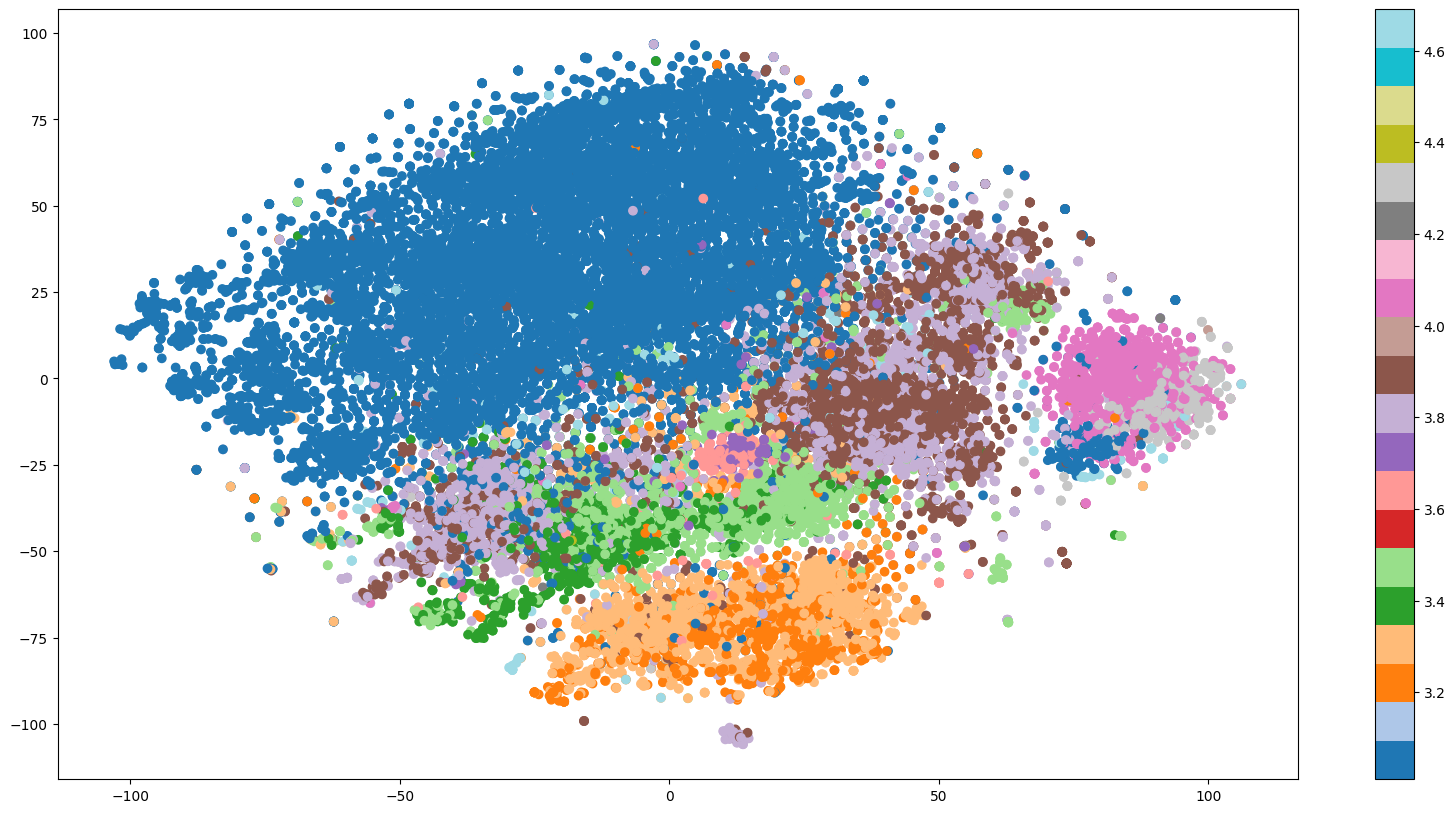

In [50]:
# Plot the results
plt.figure(figsize=(20, 10))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='tab20')
plt.colorbar()
plt.show()

In [51]:
# Create TSNE with 3 components
tsne = TSNE(n_components=3, random_state=0)
X_tsne_3d = tsne.fit_transform(X)

In [52]:
# Plot data in 3D
%matplotlib qt6

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne_3d[:,0], X_tsne_3d[:,1], X_tsne_3d[:,2], c=y, cmap='tab20')
# Add legend
plt.legend(*scatter.legend_elements(num=10), title="Classes")
plt.show()